Here, we check the footprint that we get from using the undithered fieldIDs that we consider to be in the optimized WFD footprint, and compare it with the one based on the HEALPix grid.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.db as db
import healpy as hp
import pandas as pd
import numpy as np

**Set up**

In [2]:
nside = 256
dbname = 'pontus_2002'
dbpath = '/global/cscratch1/sd/awan/dbs_wp_unzipped/pontus_2002.db'
outDir = '/global/homes/a/awan/desc/wfd_footprint/'

**Read in the data saved by WFD_extragalactic_footprint_optimized.ipynb**

In [3]:
# read in the undithered field IDs
filename = 'WFDfootprint_nside%s_undithered_fieldIDs.csv'%(nside)
fieldIDs = pd.read_csv('%s/%s'%(outDir, filename))['fieldID'].values

# read in the HEALPix pixel numbers
filename = 'WFDfootprint_nside%s_HEALPixels.csv'%(nside)
pixNums = pd.read_csv('%s/%s'%(outDir, filename))['pixNum'].values

**Set up the database and slicer to find the pixel-FOV mapping.**

In [4]:
opsdb = db.OpsimDatabase(dbpath)
simdata = opsdb.fetchMetricData(['fieldId', 'fieldRA', 'fieldDec'],  # assume v4 outputs: fieldID in v3
                                sqlconstraint=None)
slicer = slicers.HealpixSlicer(lonCol='fieldRA', latCol='fieldDec',
                               latLonDeg=opsdb.raDecInDeg, nside=nside)
slicer.setupSlicer(simdata)

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


**Now find all the HEALPix pixels that fall in our FOVs**

In [5]:
%%time
pixels_from_FOV = []

for pixel in range(hp.nside2npix(nside)):
    indObsInPixel = slicer._sliceSimData(pixel)
    ids = simdata[indObsInPixel['idxs']]['fieldId']   # fieldIDs corresponding to pixel
    for uniqID in np.unique(ids):
        if uniqID in fieldIDs:
            pixels_from_FOV.append(pixel)

CPU times: user 3min 1s, sys: 539 ms, total: 3min 2s
Wall time: 3min 1s


**Compare the original pixel list vs. that from the fIDs**

In [6]:
%%time
in_old = set(pixNums) - set(pixels_from_FOV)
print('\n%s pixels in HP list but not in the list from fIDs'%len(in_old))

in_new = set(pixels_from_FOV)-set(pixNums)
print('\n%s pixels in the list from fIDs but not in HP list\n'%len(in_new))


0 pixels in HP list but not in the list from fIDs

45963 pixels in the list from fIDs but not in HP list

CPU times: user 517 ms, sys: 52 ms, total: 569 ms
Wall time: 566 ms


**Plot skymaps**

In [7]:
nPix = hp.nside2npix(nside)
val = np.zeros(nPix)+1.
footprint = val.view(np.ma.MaskedArray)
footprint.mask = [True]*nPix
footprint.fill_value = np.nan

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.26_sim2.9.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.26_sim2.9.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.26_sim2.9.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.

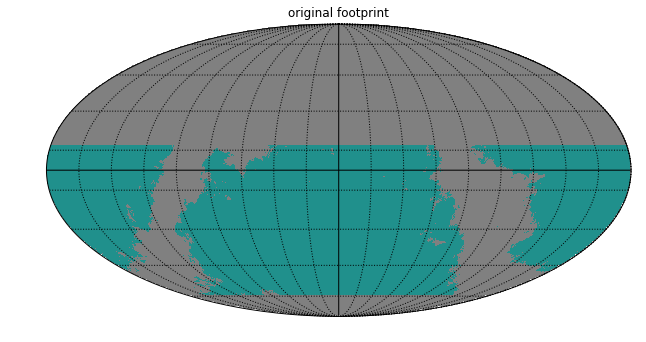

In [8]:
footprint.mask = [True]*nPix
footprint.mask[pixNums] = False

plt.clf()
hp.mollview(footprint, flip='astro', rot=(0,0,0), cbar=False,
            title='original footprint',)
hp.graticule(dpar=20, dmer=20, verbose=False)
plt.show()

/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.26_sim2.9.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.26_sim2.9.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.26_sim2.9.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.

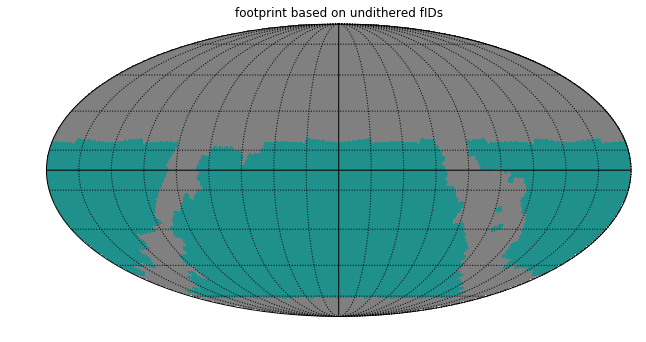

In [9]:
footprint.mask = [True]*nPix
footprint.mask[pixels_from_FOV] = False

plt.clf()
hp.mollview(footprint, flip='astro', rot=(0,0,0), cbar=False,
            title='footprint based on undithered fIDs',)
hp.graticule(dpar=20, dmer=20, verbose=False)
plt.show()

Okay so the pixel list from the fieldIDs is making the region more continuous which is great. The only problematic consequence is the appearance of the two islands around ra, dec= -110., -29 which should not be simulated.